---
title: AR Models -- Estimation and Predictions
---

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

We fit AR models by OLS of $Y$ on $X$ where $Y$ is the vector consisting of $y_{p+1}, \dots y_n$ and $X$ consists of rows $1, y_{t-1}, \dots, y_{t-p}$ for $t = p+1, \dots, n$. This gives rise to estimates $\hat{\phi}_0, \hat{\phi}_1, \dots, \hat{\phi}_p$ which are  also known as Conditional MLEs or Conditional Least Squares Estimates (conditional here refers to conditioning on $y_1, \dots, y_p$).

### Dataset One: California Population

  observation_date   CAPOP
0       1900-01-01  1490.0
1       1901-01-01  1550.0
2       1902-01-01  1623.0
3       1903-01-01  1702.0
4       1904-01-01  1792.0
125


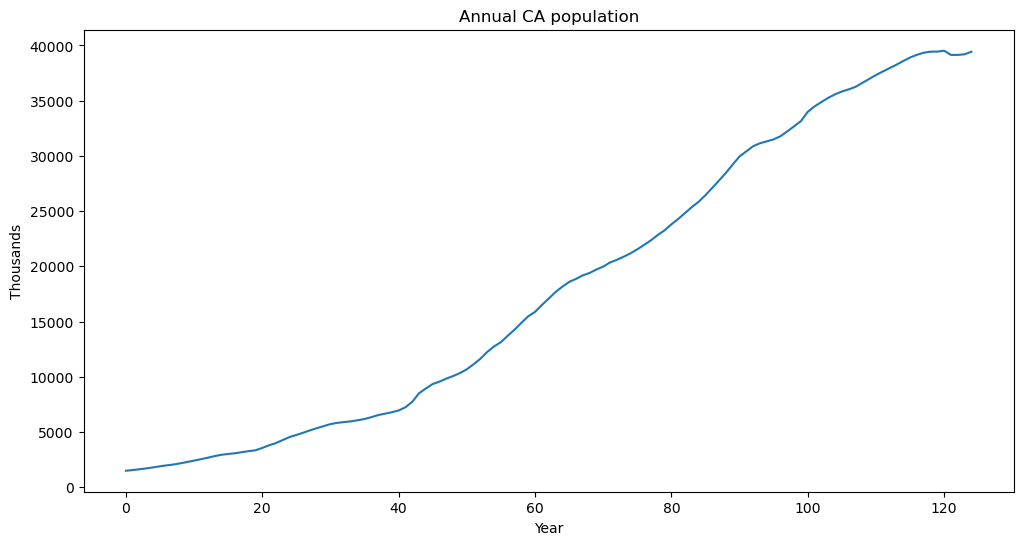

In [15]:
#California Population Dataset from FRED
capop = pd.read_csv('CAPOP_20March2025.csv')
print(capop.head())
y = capop['CAPOP'].to_numpy()
n = len(y)
print(n)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.xlabel('Year')
plt.ylabel('Thousands')
plt.title('Annual CA population')
plt.show()

We can AR(p) models to this data using the following code. 

In [6]:
p = 1
n = len(y)
yreg = y[p:] #these are the response values in the autoregression
Xmat = np.ones((n-p, 1)) #this will be the design matrix (X) in the autoregression
for j in range(1, p+1):
    col = y[p-j : n-j].reshape(-1, 1)
    Xmat = np.column_stack([Xmat, col])

armod = sm.OLS(yreg, Xmat).fit()
print(armod.params)
print(armod.summary())
sighat = np.sqrt(np.mean(armod.resid ** 2))
print(sighat)

[236.66072866   1.0038257 ]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.574e+05
Date:                Sat, 22 Mar 2025   Prob (F-statistic):          4.02e-225
Time:                        14:56:55   Log-Likelihood:                -828.87
No. Observations:                 124   AIC:                             1662.
Df Residuals:                     122   BIC:                             1667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        236.6607   

Instead of creating $y$ and $X$ and then using OLS, we can fit AR(p) model directly using the AutoReg function in statsmodels. 

In [7]:
from statsmodels.tsa.ar_model import AutoReg
armod_sm = AutoReg(y, lags = p, trend = 'c').fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  125
Model:                     AutoReg(1)   Log Likelihood                -828.870
Method:               Conditional MLE   S.D. of innovations            193.543
Date:                Sat, 22 Mar 2025   AIC                           1663.740
Time:                        14:56:56   BIC                           1672.201
Sample:                             1   HQIC                          1667.177
                                  125                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        236.6607     29.766      7.951      0.000     178.321     295.001
y.L1           1.0038      0.001    752.683      0.000       1.001       1.006
                                    Roots           

Note that "Method: Conditional MLE" in the above output. The estimates of $\hat{\phi}_0$ and $\hat{\phi}_1$ are the same in both outputs above. 

The fitted model leads to predictions for future observations which can be calculated as follows. 

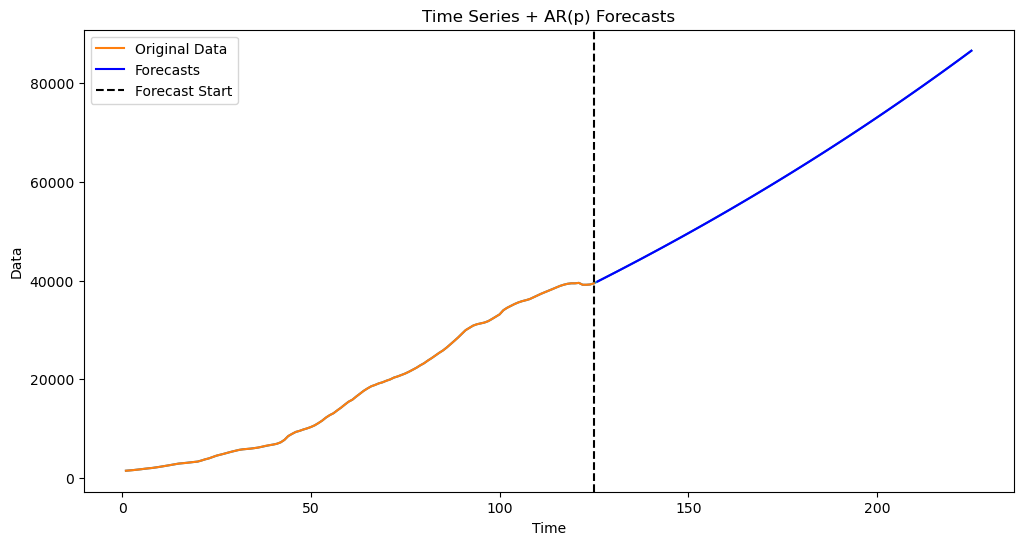

In [9]:
#Generate k-step ahead forecasts: 
k = 100 #increase k to see exponential behavior in AR(1) predictions
yhat = np.concatenate([y, np.full(k, -9999)]) #extend data by k placeholder values
phi_vals = armod.params
for i in range(1, k+1):
    ans = phi_vals[0]
    for j in range(1, p+1):
        ans += phi_vals[j] * yhat[n+i-j-1]
    yhat[n+i-1] = ans
predvalues = yhat[n:]

#Plotting the series with forecasts: 
plt.figure(figsize=(12, 6))
time_all = np.arange(1, n + k + 1)
plt.plot(time_all, yhat, color='C0')
plt.plot(range(1, n + 1), y, label='Original Data', color='C1')
plt.plot(range(n + 1, n + k + 1), predvalues, label='Forecasts', color='blue')
plt.axvline(x=n, color='black', linestyle='--', label='Forecast Start')
#plt.axhline(y=np.mean(y), color='gray', linestyle=':', label='Mean of Original Data')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Time Series + AR(p) Forecasts')
plt.legend()
plt.show()


In this AR(1) model, the fitted estimate $\hat{\phi}_1$ is slightly more than 1. So the predictions are exponential. If you increase $k$, this exponential behaviour will be become visible (when $k$ is small, the predictions look linear).

The same predictions are obtained from the AutoReg object using the predict function. 

In [10]:
predvalues_sm = armod_sm.predict(start = n, end = n+k-1)
yhat = np.concatenate([y, predvalues_sm])

Check below that both predictions lead to the same values. 

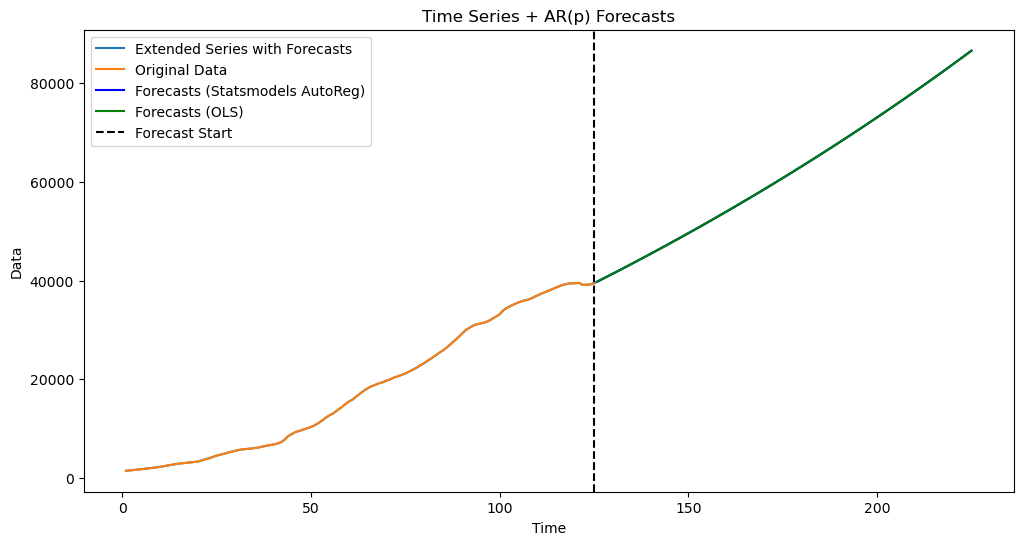

In [11]:
plt.figure(figsize=(12, 6))
time_all = np.arange(1, n + k + 1)
plt.plot(time_all, yhat, color='C0', label="Extended Series with Forecasts")
plt.plot(range(1, n + 1), y, label='Original Data', color='C1')
plt.plot(range(n + 1, n + k + 1), predvalues_sm, label='Forecasts (Statsmodels AutoReg)', color='blue')
plt.plot(range(n + 1, n + k + 1), predvalues, label='Forecasts (OLS)', color='green')
plt.axvline(x=n, color='black', linestyle='--', label='Forecast Start')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Time Series + AR(p) Forecasts')
plt.legend()
plt.show()

When $p$ changes, the predictions change appreciably. Run the code below for various values of $p$ to see how the predictions change. 

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  125
Model:                    AutoReg(25)   Log Likelihood                -601.595
Method:               Conditional MLE   S.D. of innovations             99.188
Date:                Sat, 22 Mar 2025   AIC                           1257.190
Time:                        15:01:01   BIC                           1327.530
Sample:                            25   HQIC                          1285.658
                                  125                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.5749     31.228      1.555      0.120     -12.632     109.782
y.L1           1.7693      0.100     17.607      0.000       1.572       1.966
y.L2          -0.5359      0.204     -2.632      0.0

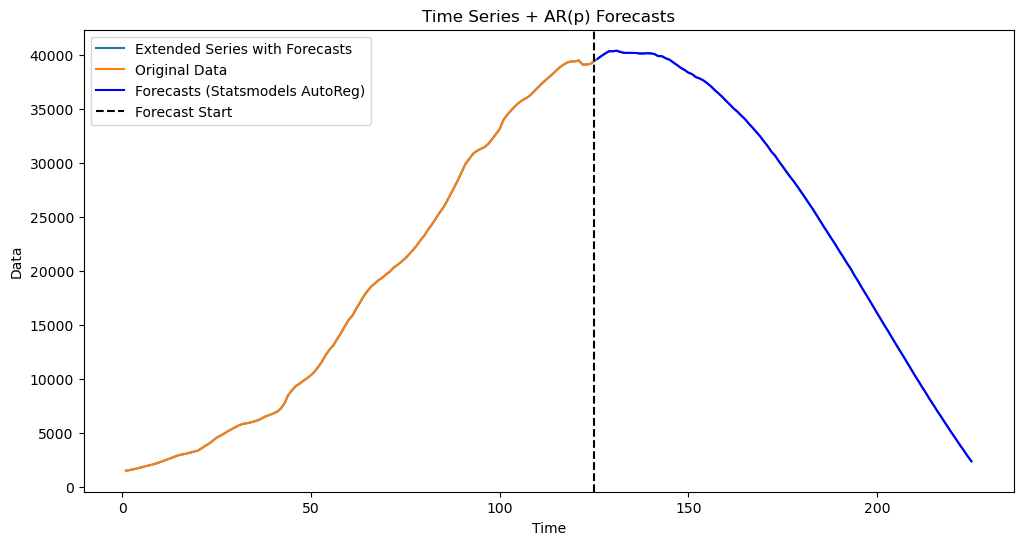

In [14]:
p = 1 #large p e.g., p = 25 leads to predictions that decrease into the future. 
armod_sm = AutoReg(y, lags = p, trend = 'c').fit()
print(armod_sm.summary())
predvalues_sm = armod_sm.predict(start = n, end = n+k-1)
yhat = np.concatenate([y, predvalues_sm])
plt.figure(figsize=(12, 6))
time_all = np.arange(1, n + k + 1)
plt.plot(time_all, yhat, color='C0', label="Extended Series with Forecasts")
plt.plot(range(1, n + 1), y, label='Original Data', color='C1')
plt.plot(range(n + 1, n + k + 1), predvalues_sm, label='Forecasts (Statsmodels AutoReg)', color='blue')
plt.axvline(x=n, color='black', linestyle='--', label='Forecast Start')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Time Series + AR(p) Forecasts')
plt.legend()
plt.show()

When $p$ is large (e.g., $p = 25$), check that the predictions decrease in time. Given that the dataset here is small ($n = 125$), the AR(25) model overfits and its predictions are not reliable. 

### Dataset Two: simulated dataset

AR(1) predictions behave quite differently in the three regimes $\phi_1 < 1$, $\phi_1 = 1$ and $\phi_1 > 1$. To see this, consider the simulated dataset below. 

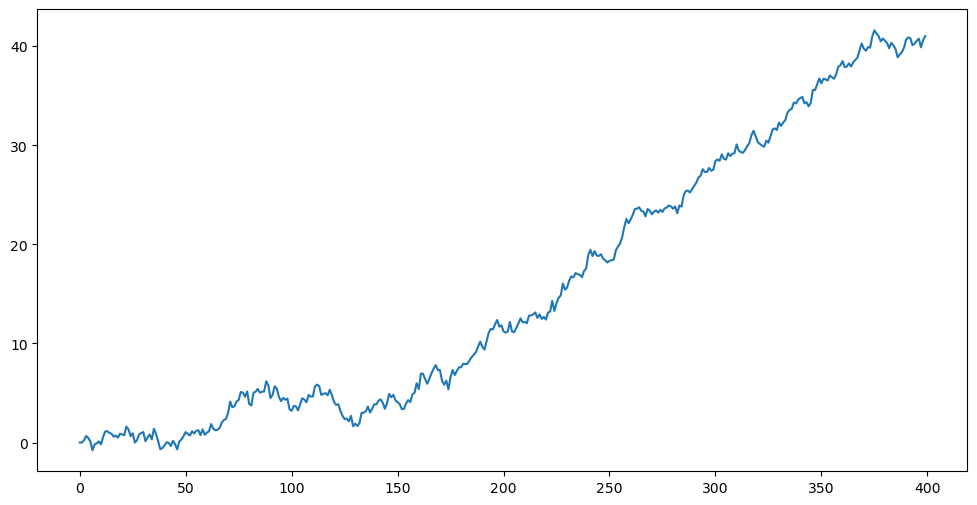

In [19]:
seed = 43
rng = np.random.default_rng(seed)
n = 400
sig = 0.5
ysim = np.zeros(n)
for i in range(2, n):
    err = rng.normal(loc = 0, scale = sig, size = 1)
    phi_0 = 0.1
    phi_1 = 1
    ysim[i] = phi_0 + phi_1 * ysim[i-1] + err[0]
plt.figure(figsize = (12, 6))
plt.plot(ysim)
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  400
Model:                     AutoReg(1)   Log Likelihood                -283.472
Method:               Conditional MLE   S.D. of innovations              0.492
Date:                Sat, 22 Mar 2025   AIC                            572.945
Time:                        15:05:19   BIC                            584.911
Sample:                             1   HQIC                           577.684
                                  400                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0705      0.037      1.891      0.059      -0.003       0.144
y.L1           1.0021      0.002    555.249      0.000       0.999       1.006
                                    Roots           

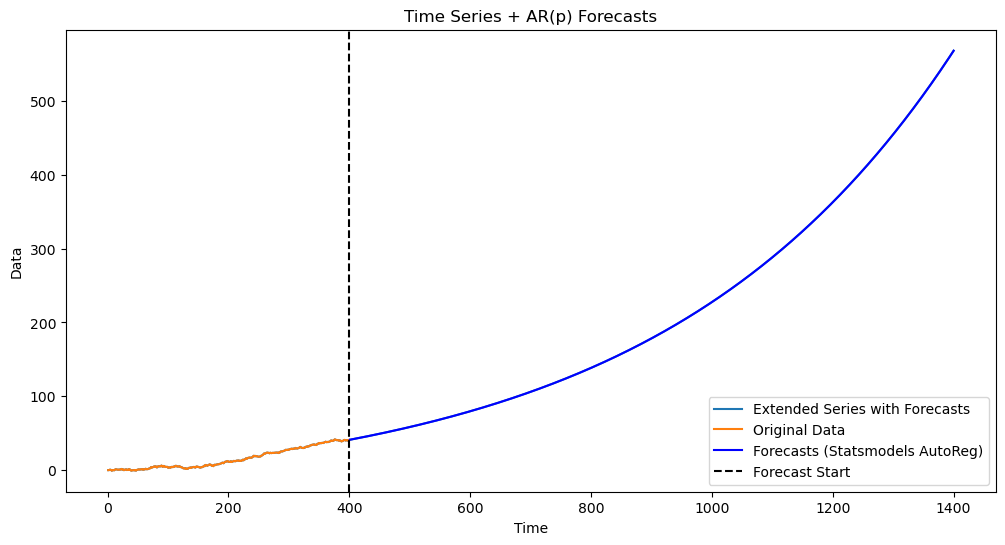

In [20]:
p = 1
armod_sm = AutoReg(ysim, lags = p, trend = 'c').fit()
print(armod_sm.summary())
k = 1000
predvalues_sm = armod_sm.predict(start = n, end = n+k-1)
yhat = np.concatenate([ysim, predvalues_sm])
plt.figure(figsize=(12, 6))
time_all = np.arange(1, n + k + 1)
plt.plot(time_all, yhat, color='C0', label="Extended Series with Forecasts")
plt.plot(range(1, n + 1), ysim, label='Original Data', color='C1')
plt.plot(range(n + 1, n + k + 1), predvalues_sm, label='Forecasts (Statsmodels AutoReg)', color='blue')
plt.axvline(x=n, color='black', linestyle='--', label='Forecast Start')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Time Series + AR(p) Forecasts')
plt.legend()
plt.show()

The estimated $\phi_1$ is more than 1 and the predictions are exponential. If we forcibly set the $\phi_1$ parameter to be 1, the predictions will be linear. This is done below. 

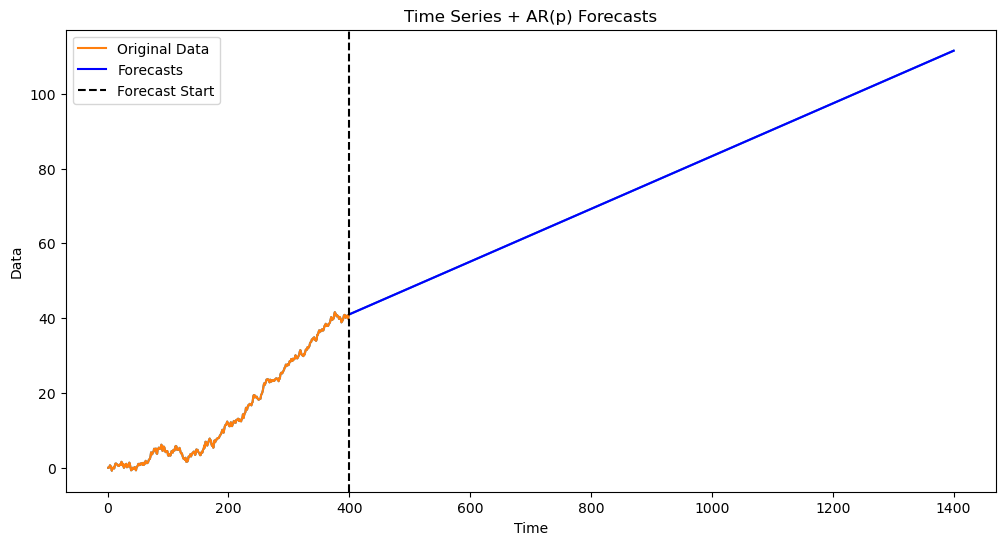

In [21]:
k = 1000
yhat = np.concatenate([ysim, np.full(k, -9999)]) #extend data by k placeholder values
phi_vals = np.array([armod_sm.params[0], 1]) #\phi_1 parameter is set to 1
for i in range(1, k+1):
    ans = phi_vals[0]
    for j in range(1, p+1):
        ans += phi_vals[j] * yhat[n+i-j-1]
    yhat[n+i-1] = ans
predvalues = yhat[n:]

#Plotting the series with forecasts: 
plt.figure(figsize=(12, 6))
time_all = np.arange(1, n + k + 1)
plt.plot(time_all, yhat, color='C0')
plt.plot(range(1, n + 1), ysim, label='Original Data', color='C1')
plt.plot(range(n + 1, n + k + 1), predvalues, label='Forecasts', color='blue')
plt.axvline(x=n, color='black', linestyle='--', label='Forecast Start')
#plt.axhline(y=np.mean(y), color='gray', linestyle=':', label='Mean of Original Data')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Time Series + AR(p) Forecasts')
plt.legend()
plt.show()

Now for the following simulated dataset, the estimated $\phi_1$ is slightly smaller than 1. This leads to predictions that decay to a constant. 

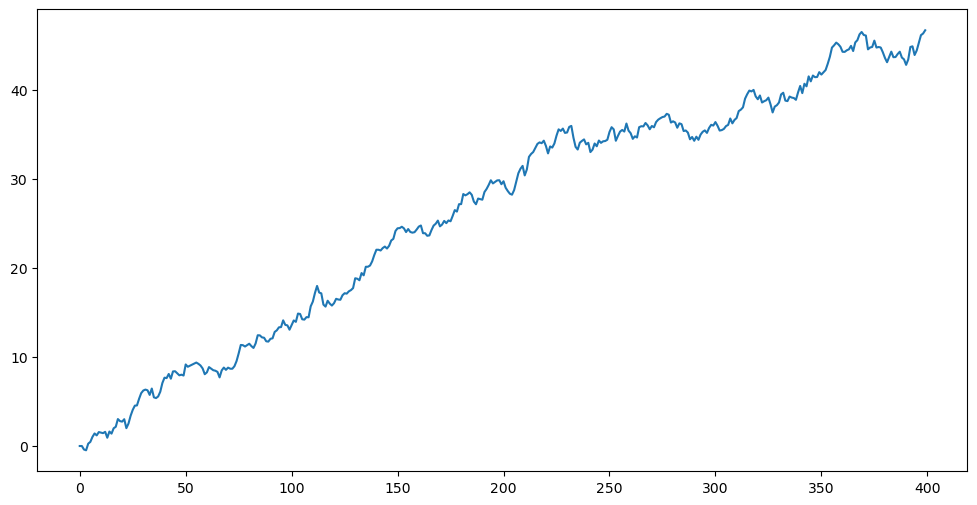

In [24]:
seed = 123
rng = np.random.default_rng(seed)
n = 400
sig = 0.5
ysim = np.zeros(n)
for i in range(2, n):
    err = rng.normal(loc = 0, scale = sig, size = 1)
    phi_0 = 0.1
    phi_1 = 1
    ysim[i] = phi_0 + phi_1 * ysim[i-1] + err[0]
plt.figure(figsize = (12, 6))
plt.plot(ysim)
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  400
Model:                     AutoReg(1)   Log Likelihood                -289.700
Method:               Conditional MLE   S.D. of innovations              0.500
Date:                Sat, 22 Mar 2025   AIC                            585.400
Time:                        15:06:45   BIC                            597.367
Sample:                             1   HQIC                           590.140
                                  400                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1857      0.055      3.391      0.001       0.078       0.293
y.L1           0.9974      0.002    538.039      0.000       0.994       1.001
                                    Roots           

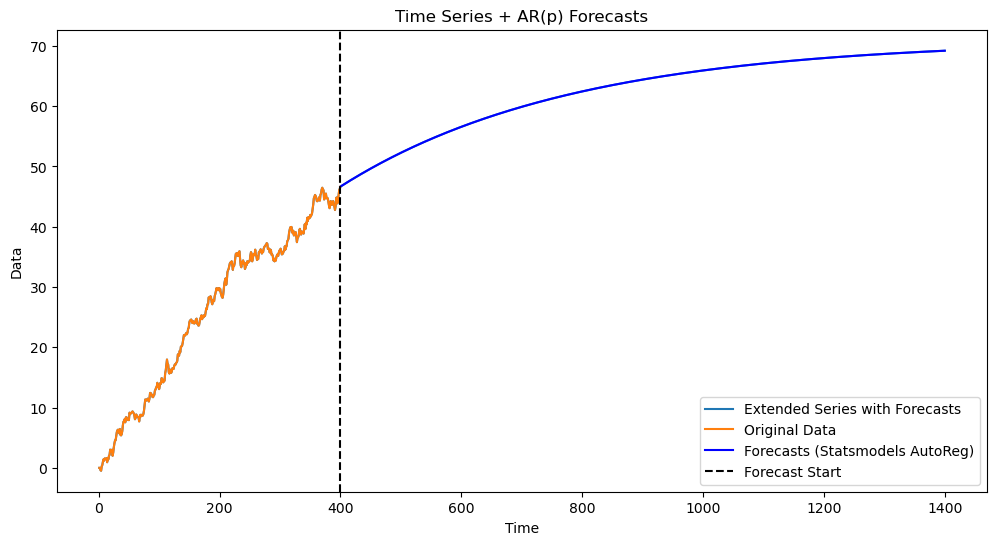

In [23]:
p = 1
armod_sm = AutoReg(ysim, lags = p, trend = 'c').fit()
print(armod_sm.summary())
k = 1000
predvalues_sm = armod_sm.predict(start = n, end = n+k-1)
yhat = np.concatenate([ysim, predvalues_sm])
plt.figure(figsize=(12, 6))
time_all = np.arange(1, n + k + 1)
plt.plot(time_all, yhat, color='C0', label="Extended Series with Forecasts")
plt.plot(range(1, n + 1), ysim, label='Original Data', color='C1')
plt.plot(range(n + 1, n + k + 1), predvalues_sm, label='Forecasts (Statsmodels AutoReg)', color='blue')
plt.axvline(x=n, color='black', linestyle='--', label='Forecast Start')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Time Series + AR(p) Forecasts')
plt.legend()
plt.show()

Again, if we force $\phi_1$ to equal 1, the predictions will be linear. 

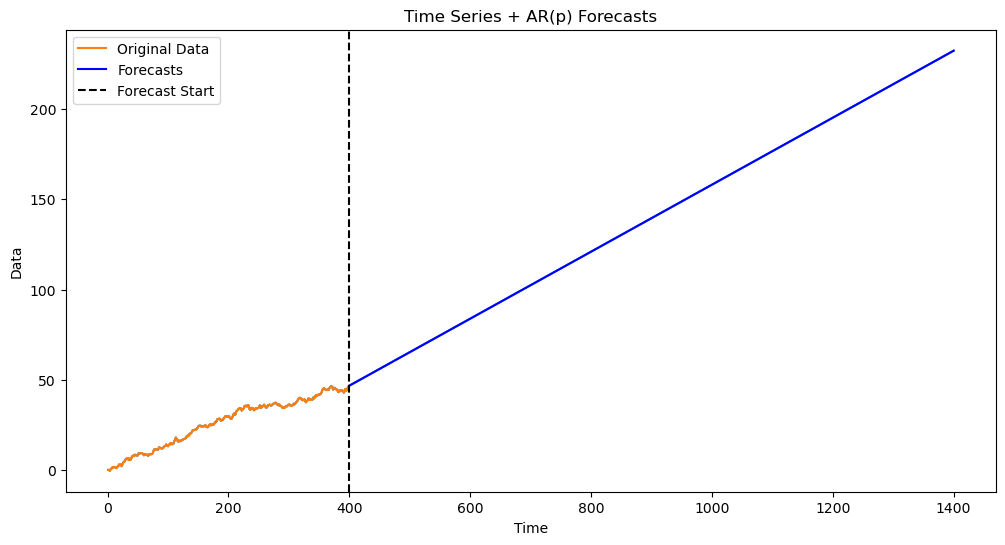

In [25]:
k = 1000
yhat = np.concatenate([ysim, np.full(k, -9999)]) #extend data by k placeholder values
phi_vals = np.array([armod_sm.params[0], 1]) #\phi_1 parameter is set to 1
for i in range(1, k+1):
    ans = phi_vals[0]
    for j in range(1, p+1):
        ans += phi_vals[j] * yhat[n+i-j-1]
    yhat[n+i-1] = ans
predvalues = yhat[n:]

#Plotting the series with forecasts: 
plt.figure(figsize=(12, 6))
time_all = np.arange(1, n + k + 1)
plt.plot(time_all, yhat, color='C0')
plt.plot(range(1, n + 1), ysim, label='Original Data', color='C1')
plt.plot(range(n + 1, n + k + 1), predvalues, label='Forecasts', color='blue')
plt.axvline(x=n, color='black', linestyle='--', label='Forecast Start')
#plt.axhline(y=np.mean(y), color='gray', linestyle=':', label='Mean of Original Data')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Time Series + AR(p) Forecasts')
plt.legend()
plt.show()

### Dataset Three: Sunspots

Predictions for AR(2) have a more richer structure than those for AR(1). In some examples (such as the sunspots dataset), AR(2) will result in predictions that oscillate (a behaviour which will never be seen in predictions for AR(1)).

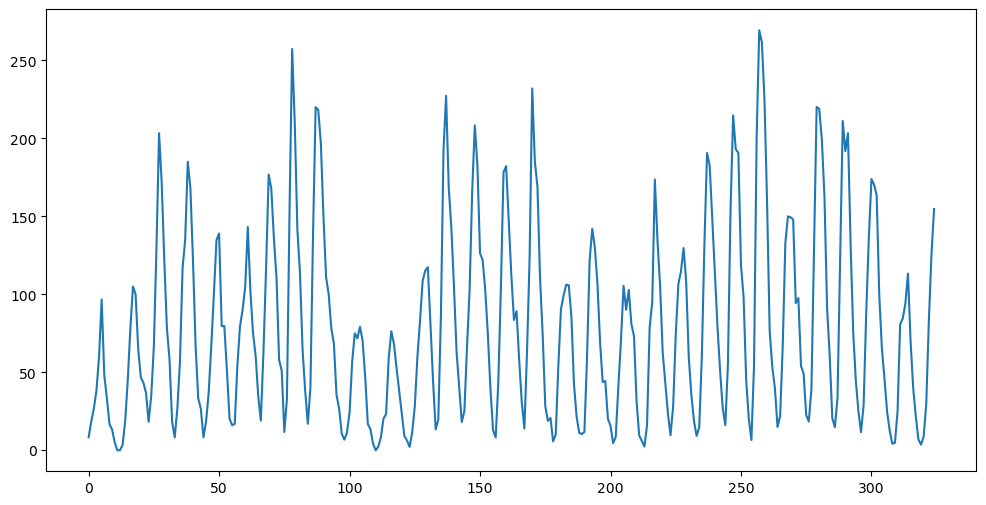

In [27]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
y = sunspots.iloc[:,1].values
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

Let us fit AR(2) model to this data. 

In [28]:
armod_sm = AutoReg(y, lags = 2, trend = 'c').fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  325
Model:                     AutoReg(2)   Log Likelihood               -1505.524
Method:               Conditional MLE   S.D. of innovations             25.588
Date:                Sat, 22 Mar 2025   AIC                           3019.048
Time:                        15:10:14   BIC                           3034.159
Sample:                             2   HQIC                          3025.080
                                  325                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4561      2.372     10.308      0.000      19.806      29.106
y.L1           1.3880      0.040     34.685      0.000       1.310       1.466
y.L2          -0.6965      0.040    -17.423      0.0

Predictions generated by the fitted AR(2) are plotted below. 

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  325
Model:                     AutoReg(2)   Log Likelihood               -1505.524
Method:               Conditional MLE   S.D. of innovations             25.588
Date:                Sat, 22 Mar 2025   AIC                           3019.048
Time:                        15:10:15   BIC                           3034.159
Sample:                             2   HQIC                          3025.080
                                  325                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4561      2.372     10.308      0.000      19.806      29.106
y.L1           1.3880      0.040     34.685      0.000       1.310       1.466
y.L2          -0.6965      0.040    -17.423      0.0

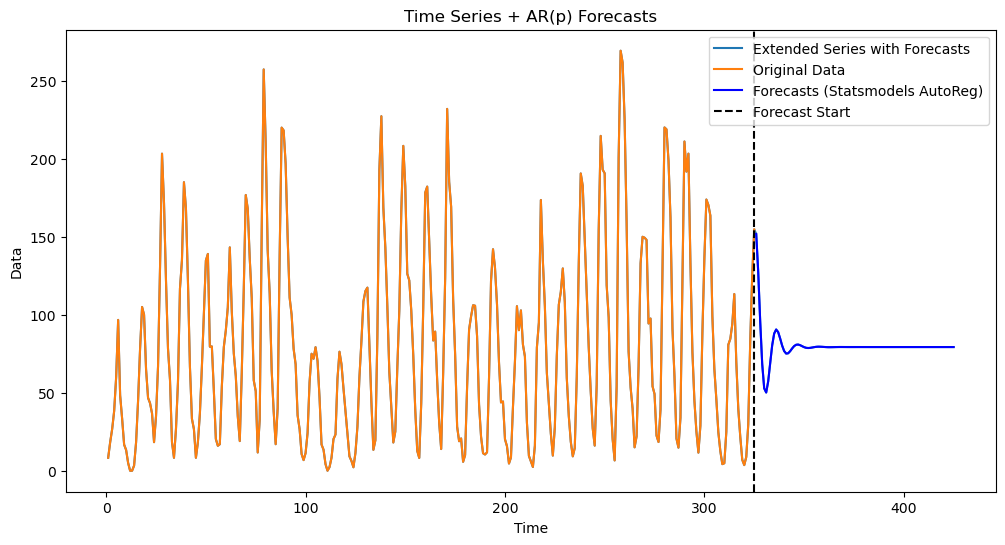

In [29]:
p = 2
armod_sm = AutoReg(y, lags = p, trend = 'c').fit()
print(armod_sm.summary())
k = 100
predvalues_sm = armod_sm.predict(start = n, end = n+k-1)
yhat = np.concatenate([y, predvalues_sm])
plt.figure(figsize=(12, 6))
time_all = np.arange(1, n + k + 1)
plt.plot(time_all, yhat, color='C0', label="Extended Series with Forecasts")
plt.plot(range(1, n + 1), y, label='Original Data', color='C1')
plt.plot(range(n + 1, n + k + 1), predvalues_sm, label='Forecasts (Statsmodels AutoReg)', color='blue')
plt.axvline(x=n, color='black', linestyle='--', label='Forecast Start')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Time Series + AR(p) Forecasts')
plt.legend()
plt.show()

The oscillating nature of the predictions are clearly visible above. We shall see some formulae (next lecture) for AR(2) predictions that explain this oscillating predictions.